In [26]:
%load_ext autoreload
%autoreload 2

from itertools import product
from utils.dgps import generate_benchmark_data
from utils.estimators import (
    twfe_fixest, twfe_fixest_compressed, twfe_statsmodels, duck_mundlak
)
from utils.benchmark import Bench
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%%capture

N_values = [1000, 10_000, 100_000, 1_000_000]
# 2-5 weeks of runtime, daily data
T_values = [14, 21, 28]
# one week prior
T0_values = [7]
iter = 3

all_benchmarks_df = pd.DataFrame()

for N, T, T0 in product(N_values, T_values, T0_values):

    bench = Bench(N = N, T = T, T0 = T0, iter = 3)
    bench.mark(fun = twfe_fixest)
    #bench.mark(fun = twfe_statsmodels)
    # add mundlak twfe via pyfixest in memory once on PyPi
    # duck_mundlak runs with 1 bootstrap iteration
    bench.mark(fun = duck_mundlak)
    
    bench_df = bench.to_dataframe()
    bench_df["N"] = N
    bench_df["T"] = T
    bench_df["T0"] = T0
    
    all_benchmarks_df = pd.concat(
        [all_benchmarks_df, bench_df], 
        axis = 0
    )

In [22]:
all_benchmarks_df.head()

,twfe_fixest,duck_mundlak,N,T,T0
0,0.015322,0.032615,1000,14,7
1,0.016094,0.030216,1000,14,7
2,0.017199,0.029118,1000,14,7
0,0.017508,0.034690,1000,21,7
1,0.017987,0.033227,1000,21,7


In [24]:
# drop first column due to numba burn-in
all_benchmarks_df_melted = all_benchmarks_df.iloc[1:,:].melt(id_vars=['N', 'T', 'T0'], value_vars=['twfe_fixest', 'duck_mundlak'], 
                    var_name='model', value_name='value')

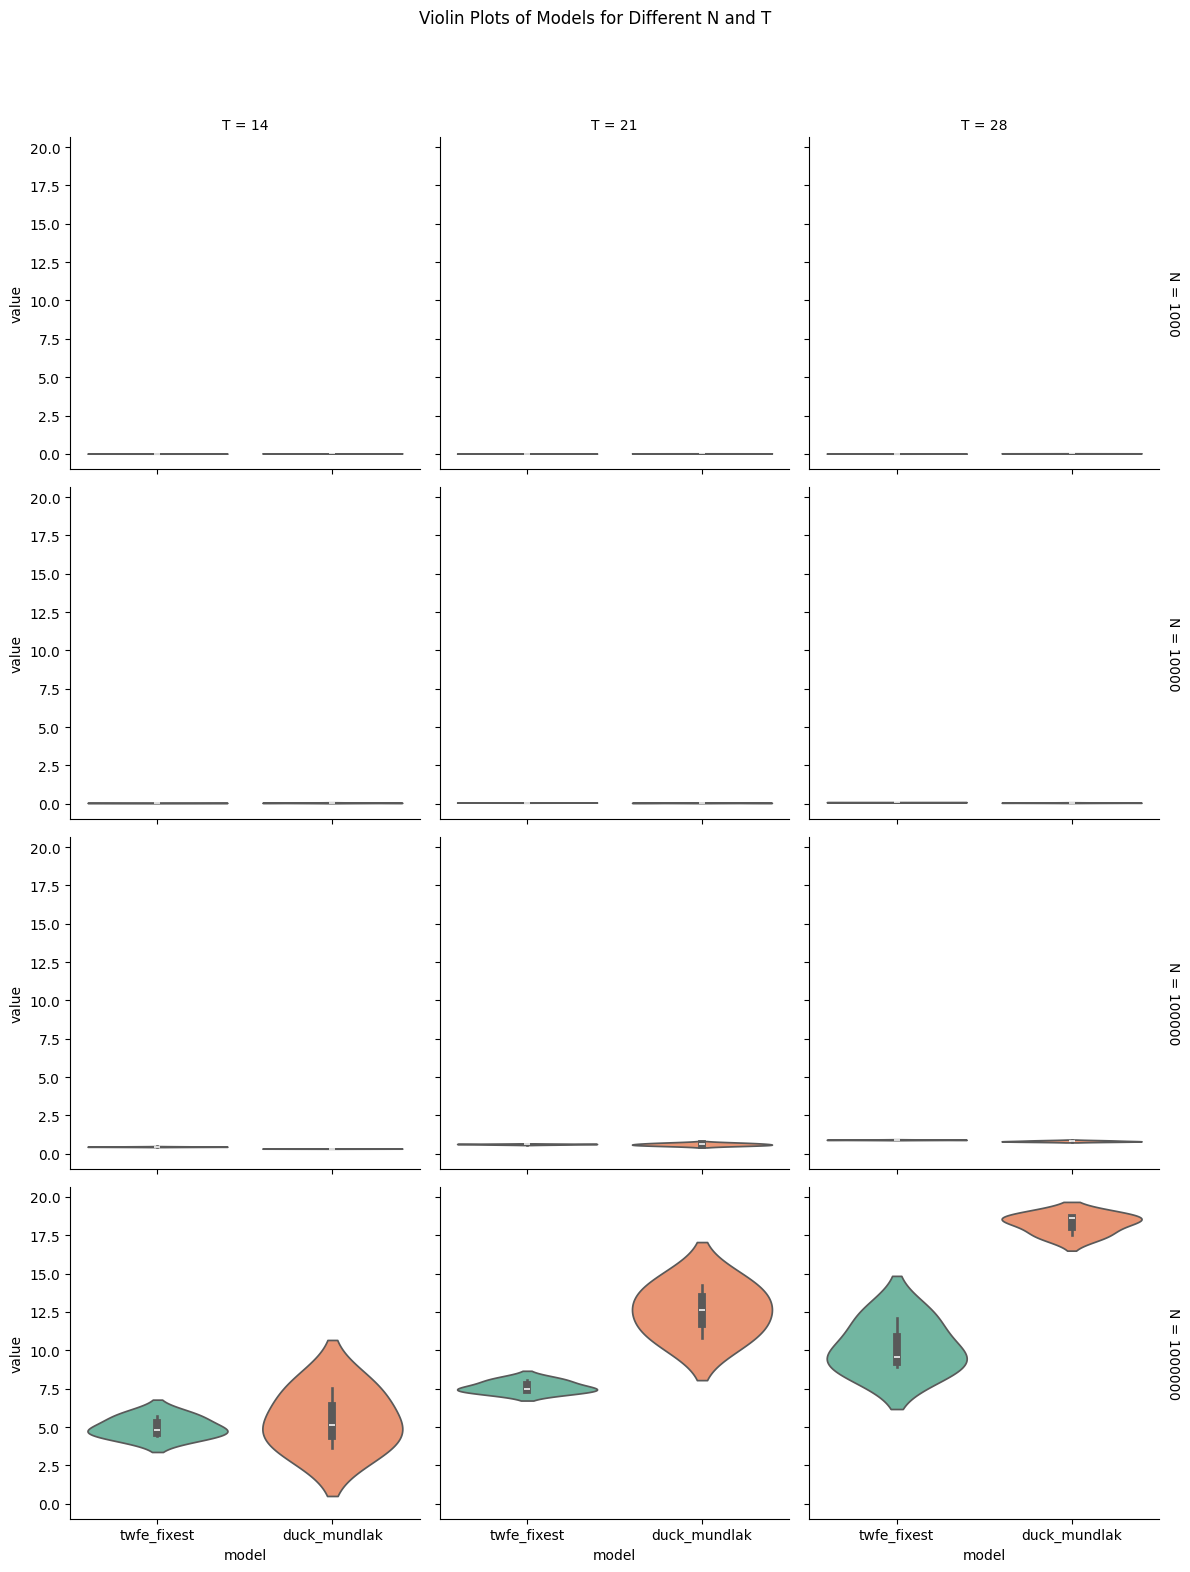

In [25]:
g = sns.FacetGrid(all_benchmarks_df_melted, col="T", row="N", margin_titles=True, height=4, aspect=1)
g.map_dataframe(sns.violinplot, x='model', y='value', hue='model', palette='Set2', legend=False)

# Adjust layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Violin Plots of Models for Different N and T')

plt.show()